In [1]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')

EPS = 10**-4

# Read and prepare data for analysis

In [2]:
sample_relationships = pd.read_table(sample_relationships_df_loc)
sample_relationships.encapsulation_sibling_sample = sample_relationships.encapsulation_sibling_sample.fillna("")
sample_relationships['emulsion'] = sample_relationships.apply(lambda x: ";".join(sorted([x.sample_uid_vdj, x.encapsulation_sibling_sample])), axis=1)
sample_relationships= sample_relationships.set_index('sample_uid_vdj')


df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'donor',
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[df.vdj_sequence.notna()]
df['emulsion'] = df.sample_uid_vdj.map(sample_relationships['emulsion'])
df['donor_subanatomical'] = df.sample_uid_vdj.map(sample_relationships['donor_subanatomical'])

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

#read and parse ASC subtype lookup table
ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)
ASC_subtype_df.columns=['barcode','subtype','sample_uid_gex']
ASC_subtype_df = ASC_subtype_df[ASC_subtype_df.sample_uid_gex.str.startswith('TBd')]
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid_gex']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()

#prepare merge column
df['cb_suid'] = df['cb'] + "_" + df['sample_uid_gex']

#copy ASC subtypes to main data frame
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']

# retain only single hq B cells 
df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)]
df_clean = df_clean[~(df_clean.celltype.str.startswith('Plasma'))]
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]



## Construct VDJ droplet count dataframe for all vdjs and those known to belong to clean B cells

In [3]:
def count_and_pivot(data_frame, index_col, column_col, 
                    fill_value=None,
                   downsample_to_smallest=False, 
                   min_vdjs_per_sample=None, 
                   n_replicates=1):

    if min_vdjs_per_sample is None:
        new_df =  data_frame.copy()
    else:
        # drop samples with fewer than min_vdjs_per_sample
        sufficiently_large_sample_uids = data_frame.groupby(column_col)[index_col].nunique()
        print('dropping the following low-VDJ samples:')
        print(sufficiently_large_sample_uids[sufficiently_large_sample_uids < min_vdjs_per_sample])
        sufficiently_large_sample_uids = sufficiently_large_sample_uids[sufficiently_large_sample_uids >= min_vdjs_per_sample].index
        new_df = data_frame[data_frame[column_col].isin(sufficiently_large_sample_uids)]

    RETAINED_SAMPLES = new_df[column_col].unique()
    #drop down to unique vdjs
    new_df = new_df.groupby([index_col, column_col]).size().reset_index()
    count_dfs = []
    for replicate_it in range(n_replicates):
        if downsample_to_smallest:
            n = int(new_df.groupby(column_col).size().min())
            # print(n)
            count_df = new_df.groupby(column_col).sample(n=n, replace=False)
            # print(count_df[column_col].value_counts())
        else:
            count_df = new_df.copy()
        if fill_value is None:
            count_df = count_df.pivot(index=index_col, columns = column_col, values=0)
        else:
            count_df = count_df.pivot(index=index_col, columns = column_col, values=0).fillna(fill_value).astype('int64')
        count_df['replicate'] = replicate_it  + 1
        count_df = count_df.reset_index().set_index([index_col, 'replicate'])
        count_dfs.append(count_df)
    
    count_df = pd.concat(count_dfs, axis=0)
    return count_df, RETAINED_SAMPLES

cell_counts_clean, RETAINED_SAMPLES = count_and_pivot(df_clean, 'vdj_sequence', 'emulsion', 
                                  downsample_to_smallest=False,
                                  min_vdjs_per_sample=None,
                                  n_replicates=1)
import warnings
warnings.filterwarnings(action='ignore')
new_cols_all = {}
for col in cell_counts_clean.columns:
    if col != 'replicate':
        new_cols_all.update({f'{col}_binned':2**round(np.log10(cell_counts_clean[col])/np.log10(2))})
        new_cols_all.update({f'{col}_binarized': cell_counts_clean[col].notna()})

new_cols_all = pd.DataFrame(new_cols_all)
cell_counts_clean = cell_counts_clean.join(new_cols_all)

sample_relationships = sample_relationships[sample_relationships.emulsion.isin(RETAINED_SAMPLES)]


## Collect celltype labels, cycling state, and hypermutation state

In [4]:

label_dict = df_clean.groupby(['emulsion', 'vdj_sequence','celltype']).size()
label_dict = label_dict.reset_index().groupby(['emulsion', 'vdj_sequence'])['celltype'].unique()
label_dict = label_dict.map(lambda x: x[0] if len(x)==1 else 'multiple')
print(label_dict.value_counts())
rare_categories = label_dict.value_counts()[label_dict.value_counts()<25].index
label_dict = label_dict.map(lambda x: 'rare celltype' if x in rare_categories else x)
celltypes = label_dict.value_counts().index
label_dict = label_dict.reset_index().pivot(columns='emulsion', index='vdj_sequence', values='celltype')
label_dict = label_dict.to_dict()


Naive B cells           90988
Memory B cells          71059
ASC-3                    6314
ASC-1                    5450
ABCs                     3001
ASC-2                    1388
multiple                  419
ASC-4                     118
GC B cells                 93
Pre-pro-B cells             5
Transitional B cells        3
Cycling B cells             3
B cells                     1
Name: celltype, dtype: int64


In [5]:
v_identity_dict = df.groupby(['vdj_sequence','v_mismatch']).size()
v_identity_dict = v_identity_dict.reset_index()[['vdj_sequence','v_mismatch']].set_index('vdj_sequence')
v_identity_dict = v_identity_dict['v_mismatch'].to_dict()


In [6]:
new_cols = {}
vdj_index = cell_counts_clean.reset_index()['vdj_sequence']
new_cols.update({'vdj_sequence':vdj_index})
for x in cell_counts_clean:
    if x.endswith('binned') or x.endswith('binarized'):
        continue
    else:
        new_col_name= f"{x}_labels"
        new_col = vdj_index.map(label_dict[x])
        new_cols.update({new_col_name:new_col})
new_cols = pd.concat(new_cols, axis=1).set_index('vdj_sequence')


In [7]:
cell_counts_clean = cell_counts_clean.merge(new_cols, left_index=True, right_index=True)
cell_counts_clean['v_identity'] = cell_counts_clean.index.map(v_identity_dict)

# Display celltype distribution of shared cells 

In [8]:
# create three lookup tables for each donor

# first a list of tissues by donor
tissue_list = ['PB','BM','SP','LN']
df_clean['donor_tissue'] = df_clean['donor'] + "_" + df_clean['tissue']
donor_tissue_list = df_clean.groupby(['donor'])['donor_tissue'].unique().to_dict()
samples = df_clean.groupby(['donor_tissue'])['emulsion'].unique().to_dict()
# second VDJ presence in each tissue

simple_presence_dfs = {donor:{} for donor in donors}
targets = [x for x in celltypes if not x in ['rare celltype','multiple']]
# third VDJ celltype in any tissue for the celltypes in targets
simple_celltype_dfs = {donor:{} for donor in donors}
for donor in donors:
    donor_label_cols = [x for x in cell_counts_clean.columns if (x.startswith((donor,";"+donor)) and x.endswith('labels'))]
    for donor_tissue in donor_tissue_list[donor]:
        tissue = donor_tissue.split("_")[-1]
        sample_list = samples[donor_tissue] 
        presence_cols = [f'{s}_binarized' for s in sample_list]
        naive = (cell_counts_clean[donor_label_cols] == 'Naive B cells').any(axis=1)


        simple_presence_dfs[donor].update({tissue
                                   :cell_counts_clean[presence_cols].sum(axis=1)>0})
    for celltype in targets:
    
        simple_celltype_dfs[donor].update({celltype
                                            :(cell_counts_clean[donor_label_cols] == celltype).any(axis=1)})
                            

for donor in donors:
    simple_presence_dfs[donor] = pd.DataFrame(simple_presence_dfs[donor])
    simple_celltype_dfs[donor] = pd.DataFrame(simple_celltype_dfs[donor])


In [9]:
def calculate_distribution(celltype_df, 
                           index_mask=None, 
                           name=None):
    if index_mask is None:
        index_mask = pd.Series(True, index=celltype_df.index)
    counts = celltype_df[index_mask].sum(axis=0)
    counts = counts/counts.sum()
    result = pd.Series(counts, name=name)

    return result

In [10]:

full_distribution_df = []
pair1=  lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['PB','BM']]
pair2 = lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['PB','SP']]
pair3 = lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['PB','LN']]
pair4 = lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['BM','SP']]
pair5 = lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['BM','LN']]
pair6 = lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['SP','LN']]

for donor in donors:
    distribution_df = []
    conditions = [
                   ('single', simple_presence_dfs[donor][[x for x in tissue_list
                                                        if x in simple_presence_dfs[donor].columns
                                                        ]].sum(axis=1)==1),
                   ('pair', simple_presence_dfs[donor][[x for x in tissue_list
                                                        if x in simple_presence_dfs[donor].columns
                                                        ]].sum(axis=1)==2),
                  ("PB,BM",simple_presence_dfs[donor][pair1(donor)].sum(axis=1)==2),
                  ("PB,SP",simple_presence_dfs[donor][pair2(donor)].sum(axis=1)==2),
                  ("PB,LN",simple_presence_dfs[donor][pair3(donor)].sum(axis=1)==2),
                  ("BM,SP",simple_presence_dfs[donor][pair4(donor)].sum(axis=1)==2),
                  ("BM,LN",simple_presence_dfs[donor][pair5(donor)].sum(axis=1)==2),
                  ("SP,LN",simple_presence_dfs[donor][pair6(donor)].sum(axis=1)==2),
                ]
    for name, condition in conditions:
        distribution = calculate_distribution(simple_celltype_dfs[donor], 
                       index_mask=condition,
                       name=name)
        distribution_df.append(distribution)
    distribution_df = pd.concat(distribution_df, axis=1).T
    distribution_df['donor'] = donor
    distribution_df = distribution_df.reset_index().rename(columns={'index':'VDJdistribution'})
    full_distribution_df.append(distribution_df)
distribution_df = pd.concat(full_distribution_df)
tissue_distribution = distribution_df.melt(id_vars=['VDJdistribution', 'donor'],
                           var_name='celltype', 
                           value_name='proportion')
tissue_distribution['OR_data'] = (EPS + tissue_distribution['proportion'])/(EPS + 1 - tissue_distribution['proportion'])



# Calculate null distributions

In [11]:
null_distribution = []


pair_conditions = [("PB,BM",simple_presence_dfs[donor][pair1(donor)].sum(axis=1)==2),
                ("PB,SP",simple_presence_dfs[donor][pair2(donor)].sum(axis=1)==2),
                ("PB,LN",simple_presence_dfs[donor][pair3(donor)].sum(axis=1)==2),
                ("BM,SP",simple_presence_dfs[donor][pair4(donor)].sum(axis=1)==2),
                ("BM,LN",simple_presence_dfs[donor][pair5(donor)].sum(axis=1)==2),
                ("SP,LN",simple_presence_dfs[donor][pair6(donor)].sum(axis=1)==2),
                ]

# calculate single and pair tissue null distributions
for donor in donors:
    dist_df = []
    pair_cells_dict = {}

    # collect per-donor per-tissue cell type distributions
    conditions = [(tissue, simple_presence_dfs[donor][tissue]) for tissue in tissue_list if tissue in simple_presence_dfs[donor].columns]
    for name, condition in conditions:
        distribution = calculate_distribution(simple_celltype_dfs[donor], 
                       index_mask=condition,
                       name=name)
        dist_df.append(distribution)
    dist_df = pd.concat(dist_df, axis=1).T

    # construct per-donor per-tissue-pair cell type null distributions
    pair_nulls = []
    for pair, condition in pair_conditions:
        t1, t2 = pair.split(",")
        if (t1 in dist_df.index) and (t2 in dist_df.index):

            t1_null = dist_df.loc[t1]
            t2_null = dist_df.loc[t2]
            pair_null = 1 - (1- t1_null)*(1 - t2_null)
            pair_null.name = pair
            pair_nulls.append(pair_null)
            pair_cells = condition.sum()
            pair_cells_dict.update({pair:pair_cells})

    pair_nulls = pd.concat(pair_nulls, axis=1).T
    dist_df = pd.concat([dist_df,pair_nulls])
    dist_df['donor'] = donor

    # calculate weights for each tissue annd tissue pair
    cell_count = simple_presence_dfs[donor].sum().to_dict()
    cell_count.update(pair_cells_dict)    
    dist_df['cells'] = dist_df.index.map(cell_count)

    single_tissue_rows = dist_df.index.str.split(",").str.len()==1
    dist_df['single_tissue_weights'] = np.nan
    weights = dist_df.loc[single_tissue_rows, 'cells']/dist_df.loc[single_tissue_rows, 'cells'].sum() 
    dist_df.loc[single_tissue_rows, 'single_tissue_weights'] = weights
    dist_df.loc['single',:] =  ((dist_df.loc[single_tissue_rows, [x for x in dist_df.columns if x in celltypes]].T * weights).T).sum() 
    dist_df.loc['single', 'donor'] = donor

    pair_tissue_rows = dist_df.index.str.split(",").str.len()>1
    dist_df['pair_tissue_weights'] = np.nan
    weights = dist_df.loc[pair_tissue_rows, 'cells']/dist_df.loc[pair_tissue_rows, 'cells'].sum() 
    dist_df.loc[pair_tissue_rows, 'pair_tissue_weights'] = weights
    dist_df.loc['pair',:] =  ((dist_df.loc[pair_tissue_rows, [x for x in dist_df.columns if x in celltypes]].T * weights).T).sum() 
    dist_df.loc['pair', 'donor'] = donor

    dist_df = dist_df.reset_index().rename(columns={'index':'VDJdistribution'})
    

    null_distribution.append(dist_df)
null_distribution = pd.concat(null_distribution)

null_distribution = null_distribution.melt(id_vars=['VDJdistribution', 
                                                    'donor', 
                                                    'single_tissue_weights', 
                                                    'pair_tissue_weights',
                                                    'cells'],
                                            var_name='celltype', 
                                            value_name='proportion')
null_distribution = null_distribution.set_index(['donor','VDJdistribution', 'celltype']).to_dict()

tissue_distribution['proportion'] = tissue_distribution['proportion'] + EPS
tissue_distribution['scaled_proportion'] = (tissue_distribution['proportion']+EPS)/(tissue_distribution.apply(lambda x: null_distribution['proportion'].get((x.donor, 
                                                                                                                x.VDJdistribution,
                                                                                                                x.celltype),1), axis=1)+EPS)
tissue_distribution

,VDJdistribution,donor,celltype,proportion,OR_data,scaled_proportion
0,single,TBd1,Naive B cells,0.572801,1.340203,1.012106
1,pair,TBd1,Naive B cells,0.000100,0.000100,0.000224
2,"PB,BM",TBd1,Naive B cells,0.000100,0.000100,0.000207
3,"PB,SP",TBd1,Naive B cells,NaN,NaN,NaN
4,"PB,LN",TBd1,Naive B cells,0.000100,0.000100,0.000218
...,...,...,...,...,...,...
379,"PB,SP",TBd6,GC B cells,0.000100,0.000100,0.930310
380,"PB,LN",TBd6,GC B cells,0.000100,0.000100,0.202981
381,"BM,SP",TBd6,GC B cells,0.000100,0.000100,0.930310
382,"BM,LN",TBd6,GC B cells,0.000100,0.000100,0.202981


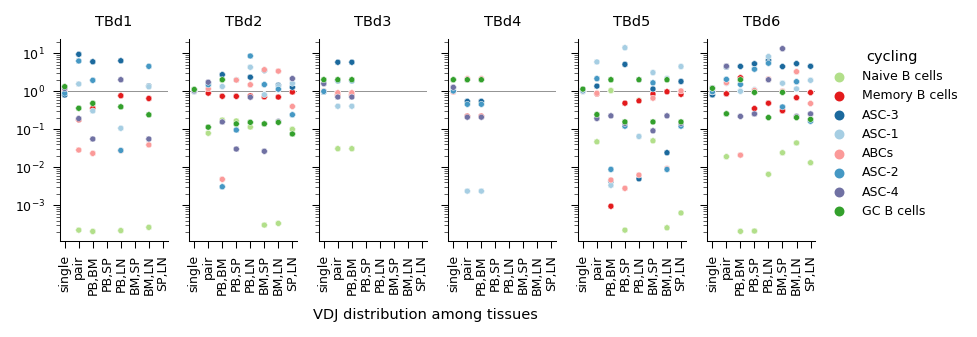

In [12]:
plt.style.use('./bursa.mplstyle')
bcelltype_colors = bcelltype_colors_alt
bcelltype_colors.update({'multiple':'k', 'rare celltype':'0.5'})
fig, axes = plt.subplots(1, 6, 
                         sharex=True, 
                         sharey=True,
                        figsize=(6.5,1.75))
axes = axes.flatten()

for i, subset in enumerate(tissue_distribution['VDJdistribution'].unique()):
    for d_it, donor in enumerate(donors):
        ax=axes[d_it]
        distributions = tissue_distribution[(tissue_distribution.donor==donor)]
        g = sns.scatterplot(distributions, 
                    x='VDJdistribution',
                    y='scaled_proportion',
                    hue='celltype',
                    palette=bcelltype_colors,
                   ax=ax,legend=((d_it==5)&(i==0)),
                    s=8
                    )
        if (d_it==5):
            g_legend = g
        ax.set_title(donor)
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
        ax.set_yscale('log')
        axes[0].set_ylabel('')
        ax.set_xlabel('')
        # ax.set_ylim([10**-3,20])
        ax.axhline(y=1, color='0.5', lw=0.5,zorder=-1, alpha=0.2)
sns.move_legend(g_legend, frameon=False, loc='upper left', bbox_to_anchor=(1,1), title='cycling', markerscale=0.75)
sns.despine(fig)
ax.set_ylabel('Fold enrichment of celltype\n abundance relative to null')
fig.supxlabel('VDJ distribution among tissues', y=-0.2, fontsize=7)
# fig.tight_layout()
fig.savefig(f'../figures/paper figures/unused/celltype_sharing_by_donor.pdf', bbox_inches='tight')

Text(-0.05, 0.9, 'd')

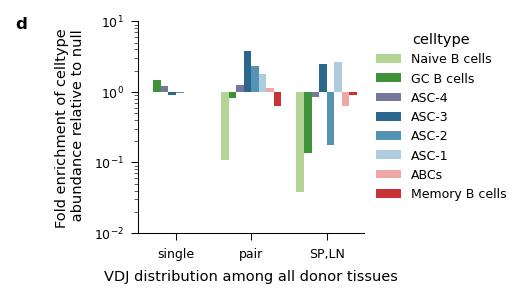

In [13]:
fig, axes = plt.subplots(1, 1, 
                         sharex=True, 
                         sharey=True,
                        figsize=(3.25,2))

tissue_data = tissue_distribution[tissue_distribution.VDJdistribution.isin(['pair','single','SP,LN'])].groupby(['VDJdistribution','celltype'])[['scaled_proportion']].mean()
tissue_data = tissue_data.reset_index()
ax=axes


order = {'single':-1, 
         'pair':0,
         'PB,BM':1,
         'BM,SP':2,
         'BM,LN':3,
         'PB,SP':4,
         'PB,LN':5,
         'SP,LN':6}
tissue_data['order'] = tissue_data.VDJdistribution.map(order)
tissue_data = tissue_data.sort_values("order")
ax=axes
# g = sns.barplot(tissue_data, 
#             x='VDJdistribution',
#             y='scaled_proportion',
#             hue='celltype',
#             palette=bcelltype_colors,
#             # bottom=1,
#             ax=ax)
ax = sns.barplot(y=tissue_data["scaled_proportion"]-1, 
                 x=tissue_data["VDJdistribution"],
                 bottom=1, 
                 hue=tissue_data['celltype'],
                 palette=bcelltype_colors)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.set_yscale('log')
ax.set_ylabel('Fold enrichment of celltype\n abundance relative to null')
ax.set_xlabel('VDJ distribution among all donor tissues')
ax.set_ylim([10**-2,10])
# ax.axhline(y=1, lw=0.5, color='0.5')
sns.move_legend(ax, 
                frameon=False, 
                loc='upper left', 
                bbox_to_anchor=(1,1),
            #    title='cycling',
               markerscale=0.75)
sns.despine(fig)
fig.tight_layout()
ax.text(-0.05,0.9, 'd', weight='bold', fontsize=8, transform=fig.transFigure)


# Now the same but for lymph nodes within donor 6

In [14]:
# create lookup tables for donor 6 lymph nodes
# first a list of tissues by donor
LN_list = ['SDLN1','SDLN2','SDLN3', 'MELN1']
samples = df_clean.groupby(['donor_subanatomical'])['emulsion'].unique().to_dict()
# # second VDJ presence in each tissue
targets = [x for x in celltypes if not x in ['rare celltype','multiple']]
# # third VDJ celltype in any tissue for the celltypes in targets
ln_presence_df = {}
ln_celltype_presence_df = {}
donor='TBd6'
donor_label_cols = [x for x in cell_counts_clean.columns if (x.startswith((donor,";")) and x.endswith('labels'))]
for subanatomical, emulsions in samples.items():
    tissue = donor_tissue.split("_")[-1]
    presence_cols = [f'{s}_binarized' for s in emulsions]

    ln_presence_df.update({subanatomical : cell_counts_clean[presence_cols].sum(axis=1)>0})
for celltype in targets:

    ln_celltype_presence_df.update({celltype:(cell_counts_clean[donor_label_cols] == celltype).any(axis=1)})
                        

ln_presence_df = pd.DataFrame(ln_presence_df)
ln_celltype_presence_df = pd.DataFrame(ln_celltype_presence_df)


In [15]:
ln_distribution_df = []
conditions = [
                ('single LN', ln_presence_df[["_".join([donor,x]) for x in LN_list]].sum(axis=1)==1),
                ('any two LNs', ln_presence_df[["_".join([donor,x]) for x in LN_list]].sum(axis=1)==2),
            ]
for name, condition in conditions:
    print(name)
    distribution = calculate_distribution(ln_celltype_presence_df, 
                    index_mask=condition,
                    name=name)
    ln_distribution_df.append(distribution)
    print(ln_distribution_df)
    
ln_distribution_df = pd.concat(ln_distribution_df, axis=1).T
ln_distribution_df['donor'] = donor
ln_distribution_df = ln_distribution_df.reset_index().rename(columns={'index':'VDJdistribution'})
LN_distribution = ln_distribution_df.melt(id_vars=['VDJdistribution', 'donor'],
                           var_name='celltype', 
                           value_name='proportion')
LN_distribution['OR_data'] = (EPS+ LN_distribution['proportion'])/(EPS + 1 - LN_distribution['proportion'])
LN_distribution

single LN
[Naive B cells     0.618885
Memory B cells    0.352877
ASC-3             0.022631
ASC-1             0.000569
ABCs              0.003819
ASC-2             0.000366
ASC-4             0.000000
GC B cells        0.000853
Name: single LN, dtype: float64]
any two LNs
[Naive B cells     0.618885
Memory B cells    0.352877
ASC-3             0.022631
ASC-1             0.000569
ABCs              0.003819
ASC-2             0.000366
ASC-4             0.000000
GC B cells        0.000853
Name: single LN, dtype: float64, Naive B cells     0.004926
Memory B cells    0.561576
ASC-3             0.394089
ASC-1             0.004926
ABCs              0.019704
ASC-2             0.009852
ASC-4             0.000000
GC B cells        0.004926
Name: any two LNs, dtype: float64]


,VDJdistribution,donor,celltype,proportion,OR_data
0,single LN,TBd6,Naive B cells,0.618885,1.623717
1,any two LNs,TBd6,Naive B cells,0.004926,0.005050
2,single LN,TBd6,Memory B cells,0.352877,0.545371
3,any two LNs,TBd6,Memory B cells,0.561576,1.280835
4,single LN,TBd6,ASC-3,0.022631,0.023255
5,any two LNs,TBd6,ASC-3,0.394089,0.650464
6,single LN,TBd6,ASC-1,0.000569,0.000669
7,any two LNs,TBd6,ASC-1,0.004926,0.005050
8,single LN,TBd6,ABCs,0.003819,0.003934
9,any two LNs,TBd6,ABCs,0.019704,0.020200


In [16]:
pair_cells_dict = {}
# calculate single and pair LN nulls

ln_null_distribution = []
conditions = [("_".join([donor,LN]), ln_presence_df["_".join([donor,LN])]) for LN in LN_list]
for name, condition in conditions:
    distribution = calculate_distribution(ln_celltype_presence_df, 
                    index_mask=condition,
                    name=name)
    ln_null_distribution.append(distribution)
ln_null_distribution = pd.concat(ln_null_distribution, axis=1).T

pairs=[ "SDLN1,SDLN2",
        "SDLN1,SDLN3",
        "SDLN2,SDLN3",
        "SDLN1,MELN1",
        "SDLN2,MELN1",
        "SDLN3,MELN1"]

pair_nulls = []
for pair in pairs:
    t1, t2 = pair.split(",")
    i1, i2 = "_".join([donor,t1]), "_".join([donor,t2])
    if (i1 in ln_null_distribution.index) and (i2 in ln_null_distribution.index):
        t1_null = ln_null_distribution.loc[i1]
        t2_null = ln_null_distribution.loc[i2]
        pair_null = 1 - (1- t1_null)*(1 - t2_null)
        pair_null.name = pair
        pair_nulls.append(pair_null)
        pair_cells = condition.sum()
        pair_cells_dict.update({pair:pair_cells})

pair_nulls = pd.concat(pair_nulls, axis=1).T
ln_null_distribution = pd.concat([ln_null_distribution,pair_nulls])
ln_null_distribution['donor'] = donor

# calculate weights for each tissue annd tissue pair
cell_count = ln_presence_df.sum().to_dict()
cell_count.update(pair_cells_dict)    
ln_null_distribution['cells'] = ln_null_distribution.index.map(cell_count)

single_ln_rows = ln_null_distribution.index.str.split(",").str.len()==1
ln_null_distribution['single_ln_weights'] = np.nan
weights = ln_null_distribution.loc[single_ln_rows, 'cells']/ln_null_distribution.loc[single_ln_rows, 'cells'].sum() 
ln_null_distribution.loc[single_ln_rows, 'single_ln_weights'] = weights
ln_null_distribution.loc['single LN',:] =  ((ln_null_distribution.loc[single_ln_rows, [x for x in ln_null_distribution.columns if x in celltypes]].T * weights).T).sum() 
ln_null_distribution.loc['single LN', 'donor'] = donor

pair_ln_rows = ln_null_distribution.index.str.split(",").str.len()>1
ln_null_distribution['pair_ln_weights'] = np.nan
weights = ln_null_distribution.loc[pair_ln_rows, 'cells']/ln_null_distribution.loc[pair_ln_rows, 'cells'].sum() 
ln_null_distribution.loc[pair_ln_rows, 'pair_ln_weights'] = weights
ln_null_distribution.loc['any two LNs',:] =  ((ln_null_distribution.loc[pair_ln_rows, [x for x in ln_null_distribution.columns if x in celltypes]].T * weights).T).sum() 
ln_null_distribution.loc['any two LNs', 'donor'] = donor

ln_null_distribution = ln_null_distribution.reset_index().rename(columns={'index':'VDJdistribution'})


ln_null_distribution = ln_null_distribution.melt(id_vars=['VDJdistribution', 'donor'],
                           var_name='celltype', 
                           value_name='proportion').set_index(['donor', 'VDJdistribution','celltype']).to_dict()
LN_distribution['proportion'] = LN_distribution['proportion'] + EPS
LN_distribution['scaled_proportion'] = (LN_distribution['proportion']+EPS)/(LN_distribution.apply(lambda x: ln_null_distribution['proportion'].get((x.donor, 
                                                                                                                x.VDJdistribution,
                                                                                                                x.celltype),1), axis=1)+EPS)
LN_distribution

,VDJdistribution,donor,celltype,proportion,OR_data,scaled_proportion
0,single LN,TBd6,Naive B cells,0.618985,1.623717,1.020762
1,any two LNs,TBd6,Naive B cells,0.005026,0.005050,0.006083
2,single LN,TBd6,Memory B cells,0.352977,0.545371,0.991571
3,any two LNs,TBd6,Memory B cells,0.561676,1.280835,0.947404
4,single LN,TBd6,ASC-3,0.022731,0.023255,0.725173
5,any two LNs,TBd6,ASC-3,0.394189,0.650464,6.377489
6,single LN,TBd6,ASC-1,0.000669,0.000669,1.044089
7,any two LNs,TBd6,ASC-1,0.005026,0.005050,3.720552
8,single LN,TBd6,ABCs,0.003919,0.003934,0.939742
9,any two LNs,TBd6,ABCs,0.019804,0.020200,2.482732


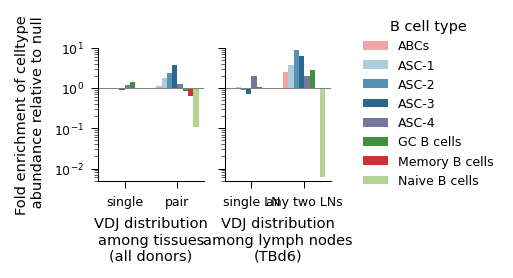

In [17]:
fig, axes = plt.subplots(1,2,figsize=(2.,1.15), sharey=True)


for it, distribution in enumerate([tissue_distribution, LN_distribution]):
    data = distribution[distribution.VDJdistribution.isin(['pair','single', 'single LN', 'any two LNs'])].groupby(['VDJdistribution','celltype'])[['proportion','scaled_proportion']].mean()
    data = data.reset_index()
    ax=axes[it]

    order = {'single':0, 
                 'pair':1,
                'PB,BM':1,
                'BM,SP':2,
                'BM,LN':3,
                'PB,SP':4,
                'PB,LN':5,
                'SP,LN':6,
                'single LN':0, 
                'any two LNs':1}

    data['order'] = data.VDJdistribution.map(order)
    data = data.sort_values(["order", 'celltype'])
    g = sns.barplot(y=data["scaled_proportion"]-1, 
                 x=data["VDJdistribution"],
                 bottom=1, 
                 ax=ax,
                 hue=data['celltype'],
                 palette=bcelltype_colors)
    if it ==0 :
        ax.get_legend().set_visible(False)
    else:
        sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), title='B cell type')


    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    ax.set_yscale('log')
    if it == 0:
        ax.set_ylabel('Fold enrichment of celltype\n abundance relative to null')
    else:
        ax.set_ylabel('')
    ax.set_ylim([5*10**-3,10])
    ax.axhline(y=1, lw=0.5, color='0.5')
    if it==1:

        ax.set_xlabel('VDJ distribution\namong lymph nodes\n(TBd6)')
    else:

        ax.set_xlabel('VDJ distribution\namong tissues\n(all donors)')

sns.move_legend(ax, 
                frameon=False, 
                loc='upper left', 
                bbox_to_anchor=(1.2,1.3))
sns.despine(fig)
# fig.tight_layout()

# ax.text(-0.01, 0.95, 'c', weight='bold', fontsize=8, transform=fig.transFigure)
# ax.text(0.5, 0.95, 'd', weight='bold', fontsize=8, transform=fig.transFigure)
fig.savefig(f'{FIGURE_OUTDIR}/Figure5/multitissue_and_multiLN_celltypes.pdf', bbox_inches='tight')

In [18]:
clone_sizes = df_clean.groupby(['donor','tissue','vdj_sequence','celltype']).size().reset_index()
clone_sizes = clone_sizes.rename(columns = {0:'count'})
clone_sizes = clone_sizes.groupby(['count', 'celltype']).size().reset_index()
clone_sizes = clone_sizes.pivot(index='count', columns='celltype',values=0)

common_celltype_distributions = (clone_sizes/clone_sizes.sum(axis=0))[['ABCs',
                                                                       'ASC-1',
                                                                       'ASC-2',
                                                                       'ASC-3',
                                                                       'ASC-4',
                                                                       'Naive B cells',
                                                                       'GC B cells',
                                                                       'Memory B cells']]


In [19]:
total_cells_by_type = clone_sizes.sum(axis=0)

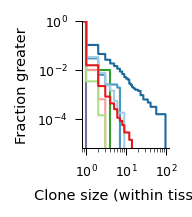

In [20]:
fig, ax = plt.subplots(figsize=(0.75,1.1))
clone_size_df = df_clean.groupby(['donor','tissue','vdj_sequence','celltype']).size().reset_index().rename(columns = {0:'count'})
clone_size_df = clone_size_df[clone_size_df.celltype.isin(['ABCs', 'ASC-1','ASC-2','ASC-3','ASC-4','Naive B cells', 'GC B cells', 'Memory B cells'])]
g = sns.ecdfplot(clone_size_df, x ='count', hue='celltype', palette=bcelltype_colors_alt, complementary=True, ax=ax, legend=False)
# sns.move_legend(g, frameon=False,bbox_to_anchor=(1,1),loc='upper left')
sns.despine(fig)
# for col in common_celltype_distributions.columns:
#     ax.plot(common_celltype_distributions[col][::-1].cumsum()[::-1], markersize=2, color = bcelltype_colors_alt[col])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Clone size (within tissue)')
ax.set_ylabel('Fraction greater')
# fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/Figure5/clone_size_distribution_by_celltype.pdf', bbox_inches='tight')
